# CNN + MaxPool
CNN with GenCode 43 data.
Merge cell lines using average of the antilogs.
Ten rounds of CV.
Use class_weights for balanced predictions.
Return to 3 epochs of training.

Analyze effect of removing the middle.
Filter train set = False.
Filter valid set = False.

TO DO:
* Retain best model.

In [1]:
from datetime import datetime
print(datetime.now())

2023-03-07 12:13:59.931658


In [2]:
try:
    from google.colab import drive
    IN_COLAB = True
    print('Running on CoLab')
    PATH='/content/drive/'
    drive.mount(PATH)
    DATA_DIR=PATH+'My Drive/data/Localization/TrainTest/TrainTest_ver43/'  # must end in "/"
except:
    IN_COLAB = False
    DATA_DIR = 'D:/Adjeroh/Localization/TrainTest/'   # Windows
    DATA_DIR = '/Users/jasonmiller/WVU/Localization/TrainTest/TrainTest_ver43/'    # Mac
print(DATA_DIR)

Running on CoLab
Mounted at /content/drive/
/content/drive/My Drive/data/Localization/TrainTest/TrainTest_ver43/


In [3]:
from platform import python_version
print('Python',python_version())
import numpy as np
import pandas as pd
import scipy.stats as ss
import pickle
import time # sleep function
from os.path import isfile
from matplotlib import pyplot as plt 
import sklearn   # pip install --upgrade scikit-learn
print('sklearn',sklearn.__version__)

import tensorflow as tf
dt='float32'
tf.keras.backend.set_floatx('float32')
tf.random.set_seed(42) 

from tensorflow import keras
from sklearn.mixture import GaussianMixture
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.metrics import auc
from sklearn.metrics import matthews_corrcoef
from sklearn.utils import class_weight

from keras.models import Sequential
from keras.layers import Masking
from keras.layers import Embedding
from keras.layers import Conv1D
from keras.layers import GlobalAveragePooling1D
from keras.layers import GlobalMaxPooling1D
from keras.layers import AveragePooling1D
from keras.layers import MaxPooling1D
from keras.layers import Bidirectional
from keras.layers import LSTM
from keras.layers import TimeDistributed
from keras.layers import Flatten
from keras.layers import Dense
from keras.layers import Dropout
from keras.losses import BinaryCrossentropy

K=4
CFILTERS=64
FILTERSIZE=16
RCELLS=32
DCELLS=16
EPOCHS=10
FOLDS=5      
EMBED_DIMEN = 4 # arbitrary hyperparameter
MINLEN=200
MAXLEN=5000   
PRETTY_PICTURES = True
RCI_THRESHOLD_MECHANISM = 'ZERO'  # 'RCI_GMM' 'ZERO' 'THE_MEAN'
BREAK = False   # break after first fold
CACHING = False   # have not worked out how to cache multiple cell lines
NUM_LINES = 15   # 15 to analyze all of them

Python 3.8.10
sklearn 1.2.1


In [4]:
RCI_FILE       = 'train.lncRNA_RCI.csv'
SEQUENCE_FILE  = 'train.canon_lncRNA_transcripts.csv'
CACHE_SEQUENCE = 'cache.seq.pickle'
CACHE_IDS      = 'cache.id.pickle'
if CACHING:
    cache_seq = DATA_DIR+CACHE_SEQUENCE 
    cache_ids = DATA_DIR+CACHE_IDS 
    if isfile(cache_seq) and isfile(cache_ids):
        print('WARNING: this run will read sequence from cache.')
    else:
        print('INFO: this run will write sequence to cache.')

In [5]:
def get_ordered_list():
    ordered_list = \
    ['A549','H1.hESC','HeLa.S3','HepG2','HT1080',\
      'HUVEC','MCF.7','NCI.H460','NHEK','SK.MEL.5',\
      'SK.N.DZ','SK.N.SH','GM12878','K562','IMR.90']
    return ordered_list
all_cell_lines = get_ordered_list()

EXCLUSIONS = [1]   # possibly exclude cell line 1 = H1.hESC

## Data Load

In [6]:
class DataLoader():
    def __init__(self):
        self.cache=dict() 
        self.vals = {'A':0, 'C':1, 'G':2, 'T':3}
        
    def load_gene_rci_values(self,filepath,exclusions):
        '''
        Load from RCI csv file.
        Return dict with keys=gene:str and values=RCI:float.
        '''
        gene_to_rci = {}
        overall_sum = 0
        with open (filepath,'r') as handle:
            header = None
            for row in handle:
                if header is None:
                    header = row # skip file's header line
                else:
                    line = row.strip()
                    fields = line.split(',')
                    gene_id = fields.pop(0)
                    cell_line_index = 0
                    rci_values = []
                    for rci_str in fields:
                        if cell_line_index not in exclusions:
                            if rci_str != "nan":
                                rci_val = float(rci_str)
                                rci_values.append(rci_val)
                        cell_line_index += 1
                    if len(rci_values)>0:
                        values = np.array(rci_values)
                        antilogs = np.power(values,2)
                        big_mean = np.mean(antilogs)
                        if np.absolute(big_mean)<0.000001:
                            log_mean = 0.0
                        else:
                            log_mean = np.log2(big_mean) 
                        gene_to_rci[gene_id] = log_mean
        print('Number of RCI values loaded',len(gene_to_rci.keys()))
        return gene_to_rci

    def seq_to_kmer_values(self,rna,K):
        vec=[] # seq converted to list of K-mers 
        N_indicator = 0 # indicator value
        length = len(rna)
        for i in range(length-K+1):
            kmer = rna[i:i+K]
            if 'N' in kmer:
                value = N_indicator
            elif kmer in self.cache.keys():
                value = self.cache[kmer]
            else:
                value = 0
                for j in range(K):
                    value *= 4   
                    nextnuc = kmer[j] 
                    nucval = self.vals[nextnuc]
                    value += nucval
                value += 1   # NNN => 0, AAA => 1
                self.cache[kmer] = value
            vec.append(value)
        return vec

    def load_sequence(self,filepath):
        allids=[]
        allseq=[]
        cache_seq = DATA_DIR+CACHE_SEQUENCE 
        cache_ids = DATA_DIR+CACHE_IDS 
        if CACHING and isfile(cache_seq) and isfile(cache_ids):
            # Warning: the cache may represent the wrong K.
            with open(cache_seq,'rb') as fin:
                allseq = pickle.load(fin)
            with open(cache_ids,'rb') as fin:
                allids = pickle.load(fin)
            return allids,allseq           
        NREPEAT = str('N'*MAXLEN)
        with open (filepath,'r') as handle:
            header = None
            for row in handle:
                if header is None:
                    header = row
                else:
                    line    = row.strip()
                    fields  = line.split(',')
                    tran_id = fields[0]  # with version number
                    gene_id = fields[1]        # without version number
                    seq_len = int(fields[3])
                    seq_txt = fields[4]
                    if seq_len>=MINLEN and seq_len<=MAXLEN and gene_id in gene_to_rci.keys():
                        allids.append( (gene_id,tran_id) )
                        if seq_len<MAXLEN:
                            seq_txt = seq_txt + NREPEAT
                            seq_txt = seq_txt[:MAXLEN]
                        hot_vec = self.seq_to_kmer_values(seq_txt,K)
                        allseq.append(hot_vec)
        if CACHING:
            with open(cache_seq,'wb') as fout:
                pickle.dump(allseq,fout)
            with open(cache_ids,'wb') as fout:
                pickle.dump(allids,fout)
        return allids,allseq

## Model

In [7]:
def build_model():
    ALPHABET=4**K+1  # NUMBER OF DISTINCT KMERS POSSIBLE, add one if N gets mask value
    ADJUST_LENGTH = MAXLEN-K+1  # fixed length sequences
    cnn = Sequential()
    embed_layer = Embedding(ALPHABET,EMBED_DIMEN,input_length=ADJUST_LENGTH,mask_zero=True)   
    cnn1_layer = Conv1D(CFILTERS, FILTERSIZE)
    pool_layer = MaxPooling1D(pool_size=FILTERSIZE, strides=FILTERSIZE//2)
    flat_layer = Flatten()
    dens_layer = Dense(DCELLS)
    drop_layer = Dropout(0.5)
    output_layer = Dense(1,activation='sigmoid',dtype=dt)

    cnn.add(embed_layer)
    cnn.add(cnn1_layer)
    cnn.add(pool_layer)
    cnn.add(flat_layer)
    cnn.add(dens_layer)
    cnn.add(drop_layer)
    cnn.add(output_layer)

    bc=BinaryCrossentropy(from_logits=False)
    cnn.compile(loss=bc, optimizer="Adam",metrics=["accuracy"])
    return cnn

In [8]:
print(datetime.now())
model=build_model()
print(model.summary())  # Print this only once
model=None

2023-03-07 12:14:31.770756
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 4997, 4)           1028      
                                                                 
 conv1d (Conv1D)             (None, 4982, 64)          4160      
                                                                 
 max_pooling1d (MaxPooling1D  (None, 621, 64)          0         
 )                                                               
                                                                 
 flatten (Flatten)           (None, 39744)             0         
                                                                 
 dense (Dense)               (None, 16)                635920    
                                                                 
 dropout (Dropout)           (None, 16)                0         
                             

## Training

In [9]:
import gc
class CrossValidator():
    def __init__(self,epochs,folds,quick_test=False,score_threshold=0.5):
        self.epochs = epochs
        self.folds = folds
        self.quick_test = quick_test
        self.score_threshold = score_threshold
        self.mechanism = 'ZERO'
        self.discriminator = None
        self.flip = False    
        self.cv_accuracy=[]
        self.cv_precision=[]
        self.cv_recall=[]
        self.cv_f1=[]
        self.cv_auprc=[]
        self.cv_auroc=[]
        self.cv_mcc=[]
        
    def set_sequences(self, allids, allseq):
        # Keep IDs and sequences in same order.
        self.all_ids = allids  # pairs of (gene_id,tran_id)
        self.all_seqs = allseq  # may be vectors of K-mers
        genes = []
        for i in range(len(allids)):
            (one_gene,one_tran) = allids[i]
            genes.append(one_gene)
        self.all_genes = genes
            
    def set_rci_map(self, gene_to_rci):
        # The map is for fast lookup, not gene order.
        self.rci_map = gene_to_rci # map gene_id to RCI value
    
    def get_gene_subset(self, sub_index):
        sub_genes = set()
        for index in sub_index:
            one_gene = self.all_genes[index]
            sub_genes.add(one_gene)
        return sub_genes   # this is a set: unordered with fast lookup
    
    def _get_X_y(self, gene_index, exclude_middle=False):
        cnt = len(self.all_ids)
        subsetX=[]
        subsetY=[]
        next_index = 0
        for i in range(cnt):
            if next_index==len(gene_index):
                break
            if i==gene_index[next_index]:
                gene_id,tran_id = self.all_ids[i]
                oneX = self.all_seqs[i]
                oneY = self.rci_map[gene_id]
                next_index += 1
                if exclude_middle and oneY >= -2 and oneY <= 0:
                    # Exclude middle from train set only, for comparison to Yuan et al
                    continue
                subsetX.append(oneX)
                subsetY.append(oneY)
        subsetX = np.array(subsetX)
        subsetY = np.array(subsetY).reshape((-1,1))
        return subsetX,subsetY
    
    def set_threshold_mechanism(self, mechanism):
        if mechanism not in ['RCI_GMM','THE_MEAN','ZERO']:
            raise Exception('Unrecognized mechansm:',mechanism)
        self.mechanism = mechanism
    
    def _apply_threshold(self, array_of_rci):
        # Takes list of float, returns list of labels [0,1].
        if self.mechanism == 'RCI_GMM':
            labels = self.discriminator.predict(array_of_rci)
            if self.flip:
                IS_CYTO = lambda label: 1 if label==0 else 0
                labels = np.array(list(map(IS_CYTO, labels)))
        else:  # 'THE_MEAN' or 'ZERO'
            rci_threshold = self.discriminator
            IS_CYTO = lambda rci: 1 if rci>rci_threshold else 0
            labels = np.array(list(map(IS_CYTO, array_of_rci)))
        return labels
    
    def _prepare_threshold(self, rci_values):
        if self.mechanism == 'RCI_GMM':
            gmm = GaussianMixture(n_components=2, verbose=0, 
                covariance_type='spherical', n_init=100) 
            gmm.fit(rci_values)
            self.flip = False
            # The GMM labels are arbitrary.
            if gmm.means_[0][0] > gmm.means_[1][0]:
                self.flip = True
            self.discriminator = gmm
        elif self.mechanism == 'THE_MEAN':
            self.discriminator = np.mean(rci_values)
        elif self.mechanism == 'ZERO':
            self.discriminator = -1   # As in Yuan et al.
        else: # not expected
            self.discriminator = 0
    
    def _explain_threshold(self):
        if self.mechanism == 'RCI_GMM':
            gmm=self.discriminator
            print('Discriminator is GMM')
            print('Means',[gmm.means_[0][0],gmm.means_[1][0]])
            print('Variances',gmm.covariances_)
            print('Priors',gmm.weights_)
            test_rcis=[-5,-4,-3.5,-3,-2.5,-2,-1.5,-1,-0.5,0,0.5,1,1.5,2,3]
            print(test_rcis)
            print(self._apply_threshold(np.array(test_rcis).reshape((-1,1))))
        else:
            print('Discriminator',self.mechanism,self.discriminator)
    
    def _show_sizes(self,label,values):
        a = np.count_nonzero(values==1)
        b = np.count_nonzero(values==0)
        print('%s 1:0 %d:%d %5.2f%%'%(label,a,b,100*a/(a+b)))
        
    def do_cross_validation(self,repetition):
        fold=0
        print(datetime.now())
        print('splitting')
        # KFold shuffles once before making the partitions
        splitter = KFold(n_splits=self.folds,shuffle=True) # random_state=42)
        splits = splitter.split(self.all_genes)
        splitter = None
        for train_index,valid_index in splits:
            fold += 1
            print('Repetition',repetition,'Fold',fold)
            X_train,y_rci = self._get_X_y(train_index,False) # exclude middle
            self._prepare_threshold(y_rci)  # use train subset only!
            self._explain_threshold()
            y_train = self._apply_threshold(y_rci)
            X_valid,y_rci = self._get_X_y(valid_index,False)  # exclude middle
            y_valid = self._apply_threshold(y_rci) 
            y_rci = None
            cw = class_weight.compute_class_weight(
                'balanced', classes=[0,1], y=y_train)
            cwd = {0: cw[0], 1: cw[1]}

            model=build_model()
            print("FIT")
            print(datetime.now())
            history=model.fit(X_train, y_train, # batch_size=10, default=32 works nicely
                epochs=self.epochs, verbose=0,  # verbose=1 for ascii art, verbose=0 for none 
                validation_data=(X_valid,y_valid) ) #class_weight=cwd,
            
            print("PREDICT")
            print(datetime.now())
            yhat_pred=model.predict(X_valid, verbose=0)             
            yhat_classes=np.where(yhat_pred > self.score_threshold, 1, 0)

            print('train class weights 1:0 %5.2f:%5.2f' % (cwd[1],cwd[0]))
            self._show_sizes('Train',y_train)
            self._show_sizes('Valid',y_valid)
            self._show_sizes('Predict',yhat_classes)

            accuracy = accuracy_score(y_valid, yhat_classes)*100.
            precision = precision_score(y_valid, yhat_classes)*100.
            recall = recall_score(y_valid, yhat_classes)*100.
            f1 = f1_score(y_valid, yhat_classes)*100.
            prc_Y, prc_X, prc_bins = precision_recall_curve(y_valid, yhat_pred)
            auprc = auc(prc_X,prc_Y)*100.
            auroc = roc_auc_score(y_valid, yhat_pred)*100.
            mcc = matthews_corrcoef(y_valid, yhat_classes)

            if PRETTY_PICTURES:
                pd.DataFrame(history.history).plot(figsize=(8,5))
                plt.grid(True)
                plt.gca().set_ylim(0,1)
                plt.show()

                print("Compute valiation accuracy")
                print('Valid sizes',X_valid.shape,y_valid.shape)
                print('Range of scores:',np.min(yhat_pred),'to',np.max(yhat_pred))
                print('Score threshold',self.score_threshold)

                count_ones= len(y_valid[y_valid==1])
                count_zeros= len(y_valid[y_valid==0])
                guess = max(count_ones,count_zeros) / len(y_valid)
                plt.plot(prc_X, prc_Y, marker='.')
                plt.plot([0, 1], [guess,guess], linestyle='--')
                plt.xlabel('Recall')
                plt.ylabel('Precision')
                plt.show()
                # ROC
                fpr, tpr, roc_bins = roc_curve(y_valid, yhat_pred)
                plt.plot(fpr, tpr, marker='.')
                plt.xlabel('False Positive Rate')
                plt.ylabel('True Positive Rate')
                plt.show()

            print('Accuracy: %.2f%% Precision: %.2f%% Recall: %.2f%%' % (accuracy,precision,recall)) 
            print('F1: %.2f%% MCC: %.2f%%' % (f1,mcc)) 
            print('AUPRC: %.2f%% AUROC: %.2f%%' % (auprc,auroc)) 
            self.cv_accuracy.append(accuracy)
            self.cv_precision.append(precision)
            self.cv_recall.append(recall)
            self.cv_f1.append(f1)
            self.cv_mcc.append(mcc)
            self.cv_auprc.append(auprc)
            self.cv_auroc.append(auroc)
            
            print(datetime.now())
            if self.quick_test:   
                print('Break -- this was for code testing only')
                break

            # There is a memory leak within the fit() command!
            # Each successive call to fit() consumes more memory.
            model = None
            history = None
            prc_Y = None
            prc_X = None
            prc_bins = None
            yhat_classes = None
            X_train = None
            y_train = None
            X_valid = None
            y_valid = None
            tf.keras.backend.clear_session()
            gc.collect()
            time.sleep(1)  # hope gc kicks in
        print()

        
    def get_statistics(self):
        return \
        self.cv_accuracy,\
        self.cv_precision,\
        self.cv_recall,\
        self.cv_f1,\
        self.cv_mcc,\
        self.cv_auprc,\
        self.cv_auroc


2023-03-07 12:16:44.231203
Number of RCI values loaded 4369
Num RCI: 4369
Load sequence...
Loaded 4236 sequences.
Cross validation...
2023-03-07 12:16:52.737955
splitting
Fold 1
Discriminator ZERO -1
FIT
2023-03-07 12:16:53.976637
PREDICT
2023-03-07 12:17:36.757539
train class weights 1:0  0.58: 3.53
Train 1:0 2908:480 85.83%
Valid 1:0 740:108 87.26%
Predict 1:0 825:23 97.29%


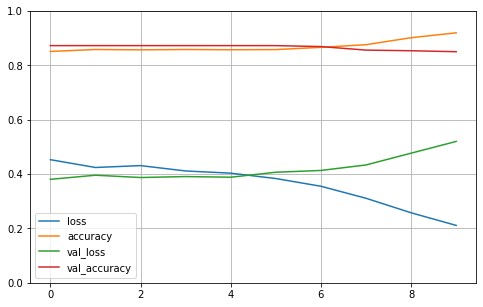

Compute valiation accuracy
Valid sizes (848, 4997) (848,)
Range of scores: 0.2485512 to 0.99999976
Score threshold 0.5


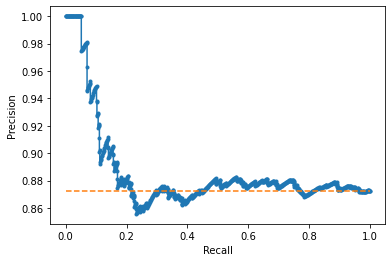

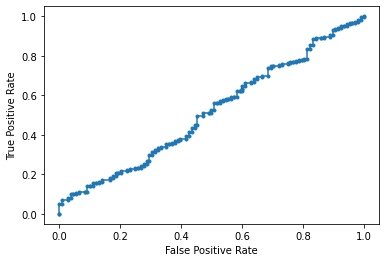

Accuracy: 85.02% Precision: 87.15% Recall: 97.16%
F1: 91.88% MCC: -0.02%
AUPRC: 88.67% AUROC: 51.53%
2023-03-07 12:17:38.216153
Fold 2
Discriminator ZERO -1
FIT
2023-03-07 12:17:41.211654
PREDICT
2023-03-07 12:17:55.552523
train class weights 1:0  0.58: 3.52
Train 1:0 2907:482 85.78%
Valid 1:0 741:106 87.49%
Predict 1:0 835:12 98.58%


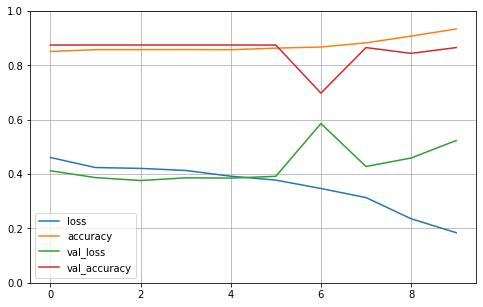

Compute valiation accuracy
Valid sizes (847, 4997) (847,)
Range of scores: 0.17898911 to 0.9999895
Score threshold 0.5


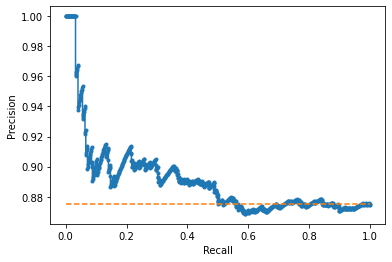

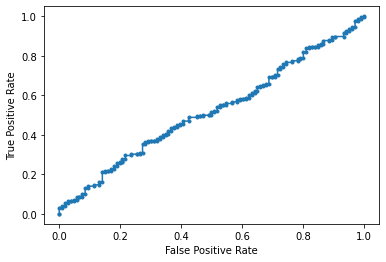

Accuracy: 86.54% Precision: 87.54% Recall: 98.65%
F1: 92.77% MCC: 0.02%
AUPRC: 89.05% AUROC: 52.04%
2023-03-07 12:17:56.437656
Fold 3
Discriminator ZERO -1
FIT
2023-03-07 12:17:58.994722
PREDICT
2023-03-07 12:18:20.699143
train class weights 1:0  0.58: 3.54
Train 1:0 2911:478 85.90%
Valid 1:0 737:110 87.01%
Predict 1:0 822:25 97.05%


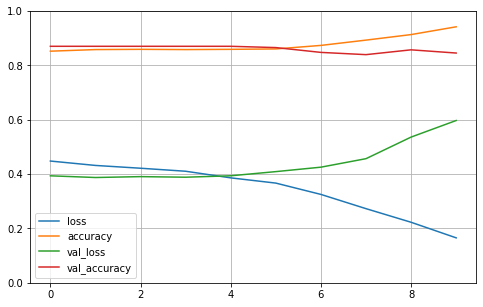

Compute valiation accuracy
Valid sizes (847, 4997) (847,)
Range of scores: 0.009450559 to 0.9999958
Score threshold 0.5


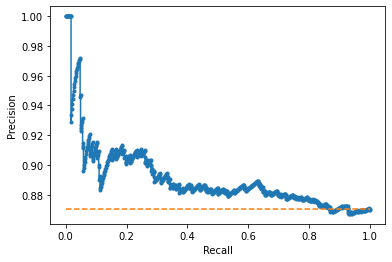

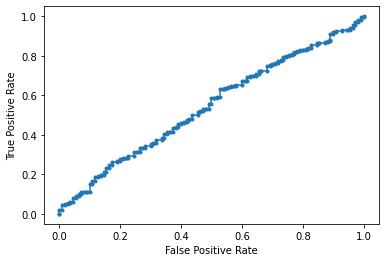

Accuracy: 84.53% Precision: 86.86% Recall: 96.88%
F1: 91.60% MCC: -0.03%
AUPRC: 89.06% AUROC: 54.46%
2023-03-07 12:18:21.788915
Fold 4
Discriminator ZERO -1
FIT
2023-03-07 12:18:24.343898
PREDICT
2023-03-07 12:18:38.354732
train class weights 1:0  0.58: 3.67
Train 1:0 2927:462 86.37%
Valid 1:0 721:126 85.12%
Predict 1:0 824:23 97.28%


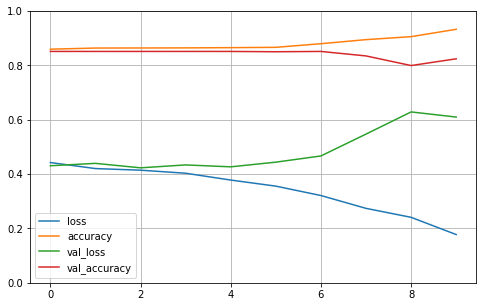

Compute valiation accuracy
Valid sizes (847, 4997) (847,)
Range of scores: 0.12732442 to 0.9999999
Score threshold 0.5


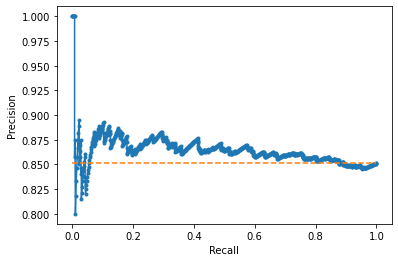

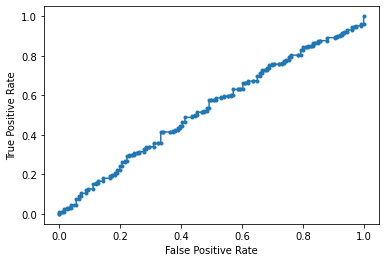

Accuracy: 82.41% Precision: 84.71% Recall: 96.81%
F1: 90.36% MCC: -0.07%
AUPRC: 86.42% AUROC: 53.17%
2023-03-07 12:18:39.247831
Fold 5
Discriminator ZERO -1
FIT
2023-03-07 12:18:41.786948
PREDICT
2023-03-07 12:19:03.746885
train class weights 1:0  0.58: 3.77
Train 1:0 2939:450 86.72%
Valid 1:0 709:138 83.71%
Predict 1:0 829:18 97.87%


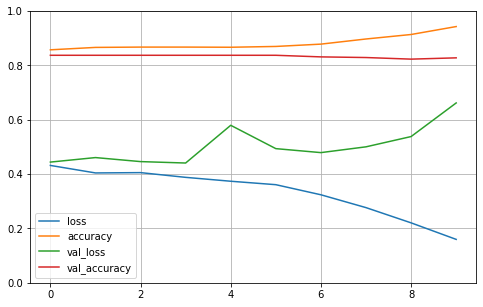

Compute valiation accuracy
Valid sizes (847, 4997) (847,)
Range of scores: 0.03307174 to 0.9999944
Score threshold 0.5


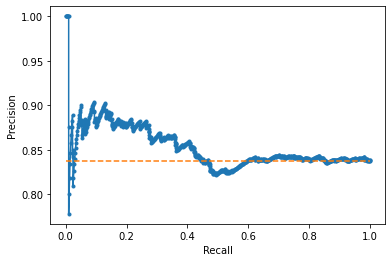

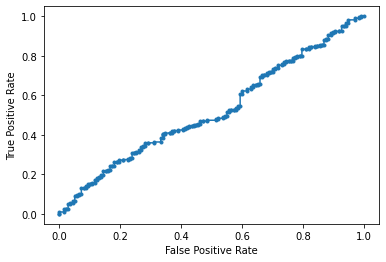

Accuracy: 82.76% Precision: 83.96% Recall: 98.17%
F1: 90.51% MCC: 0.05%
AUPRC: 85.30% AUROC: 52.17%
2023-03-07 12:19:04.800104

2023-03-07 12:19:06.175511
splitting
Fold 1
Discriminator ZERO -1
FIT
2023-03-07 12:19:07.388683
PREDICT
2023-03-07 12:19:29.317368
train class weights 1:0  0.58: 3.70
Train 1:0 2930:458 86.48%
Valid 1:0 718:130 84.67%
Predict 1:0 808:40 95.28%


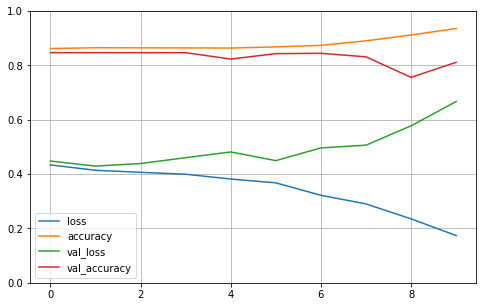

Compute valiation accuracy
Valid sizes (848, 4997) (848,)
Range of scores: 0.05026558 to 0.9999981
Score threshold 0.5


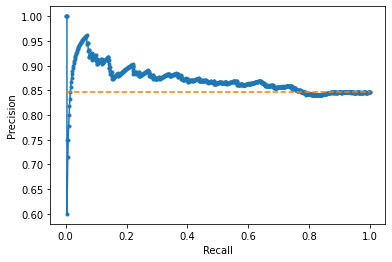

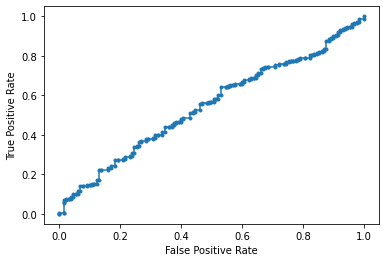

Accuracy: 81.13% Precision: 84.53% Recall: 95.13%
F1: 89.52% MCC: -0.02%
AUPRC: 87.08% AUROC: 54.59%
2023-03-07 12:19:30.397985
Fold 2
Discriminator ZERO -1
FIT
2023-03-07 12:19:32.960797
PREDICT
2023-03-07 12:19:54.835880
train class weights 1:0  0.58: 3.47
Train 1:0 2901:488 85.60%
Valid 1:0 747:100 88.19%
Predict 1:0 755:92 89.14%


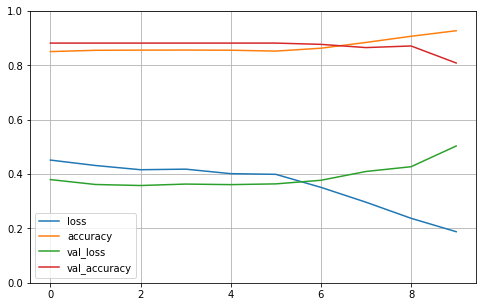

Compute valiation accuracy
Valid sizes (847, 4997) (847,)
Range of scores: 0.018759988 to 0.999998
Score threshold 0.5


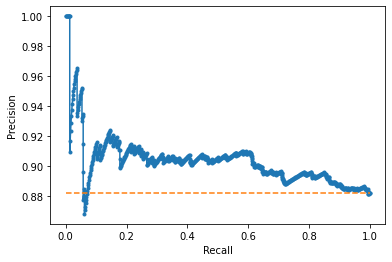

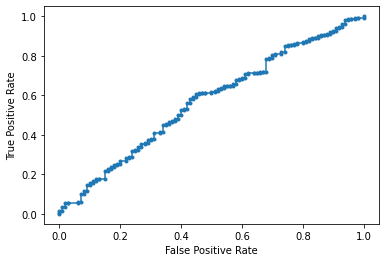

Accuracy: 80.87% Precision: 88.74% Recall: 89.69%
F1: 89.21% MCC: 0.05%
AUPRC: 90.33% AUROC: 56.94%
2023-03-07 12:19:55.761738
Fold 3
Discriminator ZERO -1
FIT
2023-03-07 12:19:58.310951
PREDICT
2023-03-07 12:20:20.009371
train class weights 1:0  0.58: 3.62
Train 1:0 2921:468 86.19%
Valid 1:0 727:120 85.83%
Predict 1:0 814:33 96.10%


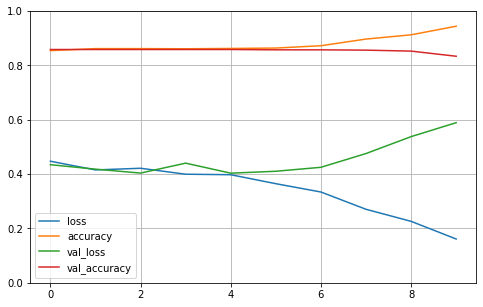

Compute valiation accuracy
Valid sizes (847, 4997) (847,)
Range of scores: 0.16297261 to 0.9999995
Score threshold 0.5


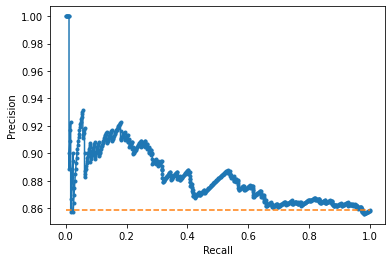

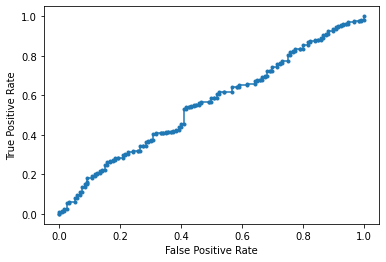

Accuracy: 83.35% Precision: 86.00% Recall: 96.29%
F1: 90.85% MCC: 0.02%
AUPRC: 88.23% AUROC: 55.38%
2023-03-07 12:20:20.969876
Fold 4
Discriminator ZERO -1
FIT
2023-03-07 12:20:23.592265
PREDICT
2023-03-07 12:20:45.325199
train class weights 1:0  0.58: 3.45
Train 1:0 2898:491 85.51%
Valid 1:0 750:97 88.55%
Predict 1:0 805:42 95.04%


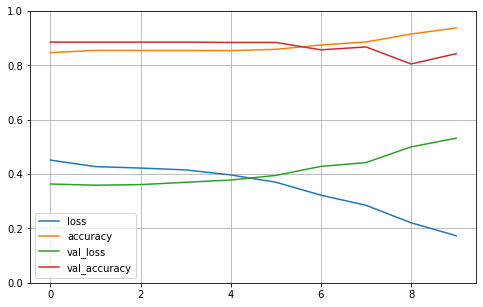

Compute valiation accuracy
Valid sizes (847, 4997) (847,)
Range of scores: 0.021345466 to 0.9999931
Score threshold 0.5


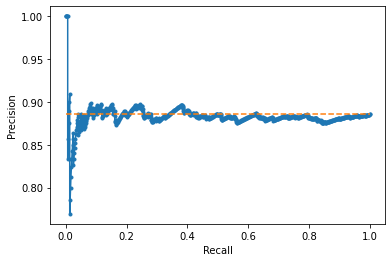

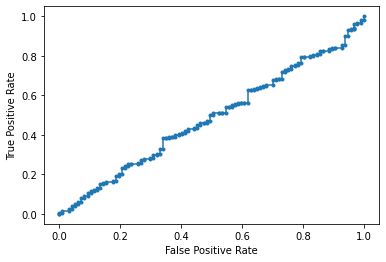

Accuracy: 84.30% Precision: 88.32% Recall: 94.80%
F1: 91.45% MCC: -0.03%
AUPRC: 88.32% AUROC: 48.51%
2023-03-07 12:20:46.266582
Fold 5
Discriminator ZERO -1
FIT
2023-03-07 12:20:50.690818
PREDICT
2023-03-07 12:21:09.103278
train class weights 1:0  0.58: 3.79
Train 1:0 2942:447 86.81%
Valid 1:0 706:141 83.35%
Predict 1:0 825:22 97.40%


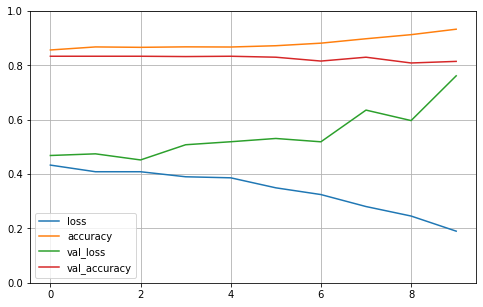

Compute valiation accuracy
Valid sizes (847, 4997) (847,)
Range of scores: 0.11958872 to 0.9999999
Score threshold 0.5


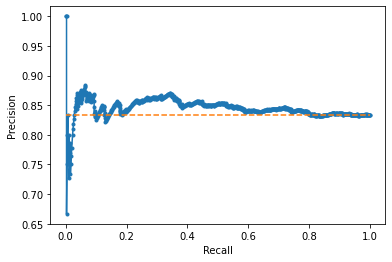

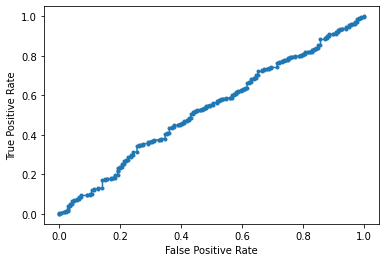

Accuracy: 81.46% Precision: 83.27% Recall: 97.31%
F1: 89.75% MCC: -0.01%
AUPRC: 84.52% AUROC: 53.20%
2023-03-07 12:21:10.016354

Completed cross validation 5 folds 10 epochs
Repeated for a total of 10 folds
 accuracy mean 83.24% std 1.86
 precision mean 86.11% std 1.91
 recall mean 96.09% std 2.54
 F1 mean 90.79% std 1.14
 MCC mean -0.00% std 0.04
 AUPRC mean 87.70% std 1.83
 AUROC mean 53.20% std 2.34

 accuracy [85.02358490566037, 86.54073199527745, 84.53364817001182, 82.40850059031877, 82.76269185360094, 81.13207547169812, 80.87367178276268, 83.3530106257379, 84.29752066115702, 81.46399055489965]
 precision [87.15151515151514, 87.54491017964072, 86.86131386861314, 84.70873786407766, 83.95657418576599, 84.52970297029702, 88.74172185430463, 85.995085995086, 88.32298136645963, 83.27272727272728]
 recall [97.16216216216216, 98.65047233468286, 96.87924016282226, 96.80998613037448, 98.16643159379407, 95.12534818941504, 89.69210174029452, 96.28610729023383, 94.8, 97.30878186968839]
 F1 [91

In [11]:
print(datetime.now())
loader = DataLoader()
filepath = DATA_DIR+RCI_FILE
gene_to_rci = loader.load_gene_rci_values(filepath,EXCLUSIONS)
print('Num RCI:', len(gene_to_rci.keys()))
print('Load sequence...')
filepath = DATA_DIR+SEQUENCE_FILE
allids,allseq = loader.load_sequence(filepath)
print('Loaded',len(allseq),'sequences.')
loader = None  # drop K-mer cache to save RAM

print("Cross validation...")
cvdo = CrossValidator(EPOCHS,FOLDS,BREAK)
cvdo.set_sequences(allids,allseq)
cvdo.set_rci_map(gene_to_rci)
cvdo.set_threshold_mechanism(RCI_THRESHOLD_MECHANISM)
# two rounds of 5 for 10 total
total_folds = 0
for F in range(2):
  total_folds += FOLDS
  cvdo.do_cross_validation(F)   
cv_accuracy,cv_precision,cv_recall,cv_f1,cv_mcc,cv_auprc,cv_auroc=\
    cvdo.get_statistics()
cvdo = None

def STD (values):
    return np.std(values,ddof=1)

print("Completed cross validation %d folds %d epochs" % (FOLDS,EPOCHS)) 
print("Repeated for a total of %d folds" % total_folds)
print(" accuracy mean %.2f%% std %.2f" %  (np.mean(cv_accuracy),  STD(cv_accuracy)))
print(" precision mean %.2f%% std %.2f" % (np.mean(cv_precision), STD(cv_precision)))
print(" recall mean %.2f%% std %.2f" %    (np.mean(cv_recall),    STD(cv_recall)))
print(" F1 mean %.2f%% std %.2f" %        (np.mean(cv_f1),        STD(cv_f1)))
print(" MCC mean %.2f%% std %.2f" %       (np.mean(cv_mcc),       STD(cv_mcc)))
print(" AUPRC mean %.2f%% std %.2f" %     (np.mean(cv_auprc),     STD(cv_auprc)))
print(" AUROC mean %.2f%% std %.2f" %     (np.mean(cv_auroc),     STD(cv_auroc)))
print()
print(" accuracy" ,  cv_accuracy)
print(" precision" , cv_precision)
print(" recall" ,    cv_recall)
print(" F1" ,        cv_f1)
print(" MCC" ,       cv_mcc)
print(" AUPRC" ,     cv_auprc)
print(" AUROC" ,     cv_auroc)
print(datetime.now())